In [1]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def downcast_dtypes(df):
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]

    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)

    return df

In [3]:
import os

data_folder = "/home/wenceslai/Documents/predict_sales_kaggle"

train = pd.read_csv(os.path.join(data_folder, 'sales_train.csv'))
item_cats = pd.read_csv(os.path.join(data_folder, 'items.csv'))
df_sub = pd.read_csv(os.path.join(data_folder, 'sample_submission.csv'))
test = pd.read_csv(os.path.join(data_folder, 'test.csv'))


# EDA and fixing abnormalities

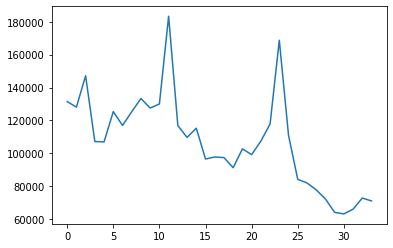

In [4]:
M_sales = train.groupby('date_block_num')['item_cnt_day'].sum()
plt.plot(range(34), M_sales)

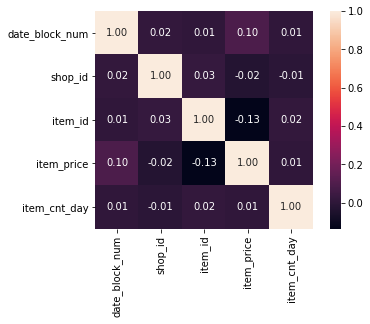

In [5]:
corr = train.corr()
sns.heatmap(data=corr, square=True, annot=True, fmt='.2f')

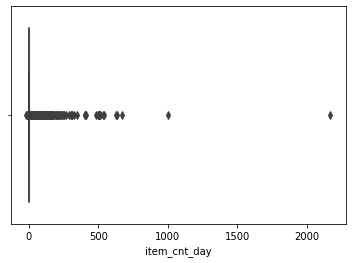

In [6]:
sns.boxplot(x=train['item_cnt_day'])

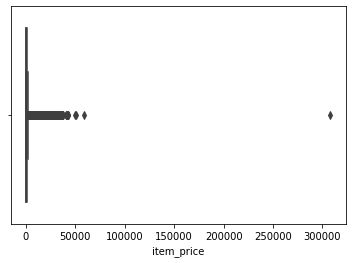

In [7]:
sns.boxplot(x=train['item_price'])

In [8]:
#weird prices and counts
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

#by the names there are some duplicate shops
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

#some prices have negative values
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median


# Aggregating data

In [9]:
"""
creating every possible pair of shop_id and item_id even if there are no sales of it in current month
we are doing this to mimic the distribution in the test data
"""

matrix = []
cols = ['date_block_num','shop_id','item_id']

for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix.sort_values(cols,inplace=True)


In [10]:
#test vals
test['date_block_num'] = 34
test = test.drop('ID', axis=1)
test = test[['date_block_num', 'shop_id', 'item_id']]


In [11]:
#aggregating item_cnt_day for whole month as in test set
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

all_data = pd.concat([matrix, test])
all_data = downcast_dtypes(all_data)

In [12]:
#adding categories
all_data = all_data.merge(item_cats.drop('item_name', axis=1), on='item_id', how='left')

# Lag features

In [13]:
def lag_features(df, lags, col):
    subset = df[['date_block_num', 'shop_id', 'item_id', col]]
    for lag in lags:
        shifted = subset.copy()
        shifted.cols = [['date_block_num', 'shop_id', 'item_id', col+"_lag_"+str(lag)]]
        shifted.rename(columns={col : col+"_lag_"+str(lag)}, inplace=True)
        shifted['date_block_num'] += lag
        df = df.merge(shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
    del shifted

    return df


In [14]:
all_data = lag_features(all_data, [1, 2, 3, 5, 12], 'item_cnt_month')

all_data.head()

/home/wenceslai/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_5,item_cnt_month_lag_12
0,0,2,19,0.0,40,0.0,0.0,0.0,0.0,0.0
1,0,2,27,1.0,19,0.0,0.0,0.0,0.0,0.0
2,0,2,28,0.0,30,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0.0,23,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0.0,40,0.0,0.0,0.0,0.0,0.0


# Mean encoding

to avoid overfitting we encode features based on one month

In [15]:
temp = all_data.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['date_block_num_meanenc']
temp.reset_index(inplace=True)

all_data = all_data.merge(temp, on=['date_block_num'], how='left')
all_data['date_block_num_meanenc'] = all_data['date_block_num_meanenc'].astype('float16')

all_data = lag_features(all_data, [1], 'date_block_num_meanenc')
all_data = all_data.drop('date_block_num_meanenc', axis=1)


/home/wenceslai/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [16]:
temp = all_data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['item_id_meanenc']
temp.reset_index(inplace=True)

all_data = all_data.merge(temp, on=['date_block_num', 'item_id'], how='left')
all_data['item_id_meanenc'] = all_data['item_id_meanenc'].astype('float16')

all_data = lag_features(all_data, [1], 'item_id_meanenc')
all_data = all_data.drop('item_id_meanenc', axis=1)


/home/wenceslai/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [17]:
temp = all_data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['shop_id_meanenc']
temp.reset_index(inplace=True)

all_data = all_data.merge(temp, on=['date_block_num', 'shop_id'], how='left')
all_data['shop_id_meanenc'] = all_data['shop_id_meanenc'].astype('float16')

all_data = lag_features(all_data, [1, 2, 3, 5, 12], 'shop_id_meanenc')
all_data = all_data.drop('shop_id_meanenc', axis=1)


/home/wenceslai/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [18]:
temp = all_data.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['item_category_id_meanenc']
temp.reset_index(inplace=True)

all_data = all_data.merge(temp, on=['date_block_num', 'item_category_id'], how='left')
all_data['item_category_id_meanenc'] = all_data['item_category_id_meanenc'].astype('float16')

all_data = lag_features(all_data, [1], 'item_category_id_meanenc')
all_data = all_data.drop('item_category_id_meanenc', axis=1)


/home/wenceslai/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [19]:
all_data.isnull().sum()

date_block_num                    0
shop_id                           0
item_id                           0
item_cnt_month                    0
item_category_id                  0
item_cnt_month_lag_1              0
item_cnt_month_lag_2              0
item_cnt_month_lag_3              0
item_cnt_month_lag_5              0
item_cnt_month_lag_12             0
date_block_num_meanenc_lag_1      0
item_id_meanenc_lag_1             0
shop_id_meanenc_lag_1             0
shop_id_meanenc_lag_2             0
shop_id_meanenc_lag_3             0
shop_id_meanenc_lag_5             0
shop_id_meanenc_lag_12            0
item_category_id_meanenc_lag_1    0
dtype: int64

# Price and special features
I was not really succesful with price features but I managed to engineer some new special time ones.

In [20]:
"""
this left 20% nan values so i left it out of final dataframe

prices = train.groupby(['date_block_num', 'item_id']).agg({'item_price' : ['mean']})
prices.columns = ['avg_price_month']
prices = prices.reset_index()
prices.head()

all_data = all_data.merge(prices, on=['date_block_num', 'item_id'], how='left')

this feature only worsen the performance

prices = train.groupby('item_id').agg({'item_price' : ['mean']})
prices.columns = ['avg_price_total']
prices = prices.reset_index()

all_data = all_data.merge(prices, on='item_id', how='left')
all_data = all_data.fillna(0)
"""

"\nthis left 20% nan values so i left it out of final dataframe\n\nprices = train.groupby(['date_block_num', 'item_id']).agg({'item_price' : ['mean']})\nprices.columns = ['avg_price_month']\nprices = prices.reset_index()\nprices.head()\n\nall_data = all_data.merge(prices, on=['date_block_num', 'item_id'], how='left')\n\nthis feature only worsen the performance\n\nprices = train.groupby('item_id').agg({'item_price' : ['mean']})\nprices.columns = ['avg_price_total']\nprices = prices.reset_index()\n\nall_data = all_data.merge(prices, on='item_id', how='left')\nall_data = all_data.fillna(0)\n"

In [21]:
#adding seasonality in forms of month
all_data['month'] = all_data['date_block_num'] % 12

In [22]:
#adding number of days in a month
num_of_days = {0 : 31, 1 : 28, 2 : 31, 3 : 30, 4 : 31, 5 : 30, 6 : 31, 7 : 31, 8 : 30, 9 : 31, 10 : 30, 11 : 31}

all_data['num_of_days'] = all_data['month'].map(num_of_days)

In [23]:
#adding year
def year(x):
    return 2013 + x // 12

all_data['year'] = all_data.apply(lambda row: year(row['date_block_num']), axis=1)

# Training / Validation
For validation i uses first months <= 32 and for validation month 33, which means it is a hold out set validation shcheme

In [24]:
val_tresh = 34 #set to 34 if we do not want to validate

all_data = all_data[all_data['date_block_num'] > 11] #because maximum lag used 12 we can delete lagged months

X_train = all_data[all_data['date_block_num'] < val_tresh].drop('item_cnt_month', axis=1).values
y_train = all_data.loc[all_data['date_block_num'] < val_tresh]['item_cnt_month'].values


X_val = all_data[all_data['date_block_num'] == val_tresh].drop('item_cnt_month', axis=1).values
y_val = all_data[all_data['date_block_num'] == val_tresh]['item_cnt_month'].values

X_test = all_data[all_data['date_block_num'] == 34].drop('item_cnt_month', axis=1).values

y_train = y_train.clip(0, 20)
y_val = y_val.clip(0, 20)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)


(6425094, 20) (6425094,) (214200, 20) (214200,) (214200, 20)


# Training and Ensembling

In [ ]:
#Random forests - tree based method
#Did not use it in final ensembling becuase training was long and did not perform very well

from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_jobs=-1, verbose=1, n_estimators=50, max_depth=25, random_state=18)
model_rf.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

y_preds = model_rf.predict(X_val).clip(0, 20)

rmse = np.sqrt(mean_squared_error(y_val, y_preds))
print("validation RMSE:", rmse)


In [25]:
#XGBoost - tree based method 
from xgboost import XGBRegressor 

model_xgb = XGBRegressor(
    max_depth=8,
    n_estimators=42,
    min_child_weight=300,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.3,
    seed=42)

model_xgb.fit(
    X_train,
    y_train,
    #eval_metric="rmse",
    #eval_set=[(X_train, y_train), (X_val, y_val)]
    #early_stopping_rounds = 9
    verbose=True
    )


[22:09:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:09:00] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(colsample_bytree=0.8, eta=0.3, max_depth=8, min_child_weight=300,
             n_estimators=42, seed=42, subsample=0.8)

In [27]:
#Neural Network - linear model
from keras import models
from keras import layers
from tensorflow.keras import backend as K

model_nn = models.Sequential()
model_nn.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(layers.Dense(32, activation='relu',))
model_nn.add(layers.Dense(1))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model_nn.compile(
    optimizer='rmsprop',
    loss=root_mean_squared_error,
    metrics=[root_mean_squared_error]
)


Using TensorFlow backend.


In [37]:
model_nn.fit(
    X_train, y_train,
    #validation_data=(X_val, y_val),
    epochs=1,
    batch_size=64,
    verbose=True
)

Epoch 1/1
6425094/6425094 [==============================] - 361s 56us/step - loss: 0.8112 - root_mean_squared_error: 0.8112


In [38]:
preds_xgb = model_xgb.predict(X_test).clip(0, 20) #ensebling
preds_nn = model_nn.predict(X_test).clip(0, 20).squeeze()

preds = 0.7 * preds_xgb + 0.3 * preds_nn

df_sub['item_cnt_month'] = preds #round?
df_sub.to_csv(os.path.join(data_folder, 'sub_out_xgb_nn'), index=False)
print("done")

done
